In [1]:
# # # Copyright (C) 2022  Syed Salman Habeeb Quadri
# # # https://github.com/SalmanHabeeb/INR-Predictor/blob/main/License%20Notice.md

In [2]:
# !pip install q tensorflow==2.8.2
# !pip install q keras==2.8.0
# !pip install q numpy==1.21.6
# !pip install q matplotlib==3.2.2
# !pip install q pandas==1.3.5
# !pip install q scipy==1.4.1
# !pip install q sklearn==1.0.2

## Import necessary packages

In [3]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, LSTM, Dense
from keras.layers.embeddings import Embedding
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import r2_score
from scipy.stats import linregress

## Obtaining data

Read the csv file from the github repository

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/SalmanHabeeb/INR-Predictor/main/INR=X.csv')

## Checking the dataset

Checking information regarding dataset

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4824 entries, 0 to 4823
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4824 non-null   object 
 1   Open       4792 non-null   float64
 2   High       4792 non-null   float64
 3   Low        4792 non-null   float64
 4   Close      4792 non-null   float64
 5   Adj Close  4792 non-null   float64
 6   Volume     4792 non-null   float64
dtypes: float64(6), object(1)
memory usage: 263.9+ KB
None


Checking various statistics of dataset

In [6]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4792.000000,4792.000000,4792.000000,4792.000000,4792.000000,4792.0
mean,56.877448,57.080264,56.695116,56.878949,56.878949,0.0
std,11.759593,11.791577,11.706153,11.773224,11.773224,0.0
min,38.995998,39.235001,38.979000,39.044998,39.044998,0.0
25%,45.356248,45.493749,45.268002,45.348749,45.348749,0.0
50%,55.496500,55.723999,55.299999,55.498001,55.498001,0.0
75%,67.136251,67.300753,66.919998,67.133003,67.133003,0.0
max,77.820000,78.023804,77.498497,77.820000,77.820000,0.0


Sampling a roughly 0.1% of dataset

In [7]:
df.sample(frac = 0.001)

,Date,Open,High,Low,Close,Adj Close,Volume
1222,2008-08-06,NaN,NaN,NaN,NaN,NaN,NaN
3990,2019-03-18,68.953003,69.239998,68.455002,68.953003,68.953003,0.0
2290,2012-09-10,55.358002,55.480000,55.259998,55.358002,55.358002,0.0
2482,2013-06-05,56.487999,56.848000,56.307999,56.438000,56.438000,0.0
1744,2010-08-06,46.049999,46.174999,45.950001,46.056000,46.056000,0.0


## Data Cleaning

Finding the no. of missing rows.

For approximately 18 years of data, we expect the dataset to have 18*365 rows, one for each day

In [8]:
expected_no_of_rows  = 18*365

In [9]:
actual_no_of_rows = df.shape[0]

In [10]:
missing_rows = expected_no_of_rows - actual_no_of_rows

In [11]:
missing_rows

1746

However, the no. of missing rows is about 1700. This amounts to about 5 years of data missing in between. 

Apart from missing rows, the data we have may also contain null values.

Let's check the the no. of null values

In [12]:
df.isna().sum()

Date          0
Open         32
High         32
Low          32
Close        32
Adj Close    32
Volume       32
dtype: int64

Since there are only 32 rows containing null values, we drop these rows.

In [13]:
df.dropna(inplace = True)

As seen before, missing rows cost us 30% of data points. To fill the missing rows, we adapt a unique strategy. This involves:

(i) Creating a range of dates in the same range as our dataset. Initialize the exchange rate column in this new dataframe with zeros.

(ii) Assigning exchange rates to these dates from the values of corresponding dates of original dataset

(iii) Fill the remaining zeros with exchange rates estimated from preceding and succeeding values. In case succeeding value is missing, replace the range of missing values with appropriate linear estimates from succeeding value and preceding value.

(iv)To model the real data, add some random values to above computed values.

In [17]:
new = pd.DataFrame(pd.date_range(start = df.iloc[0, 0], end = df.iloc[-1, 0]))    #Make a dataframe having with dates from start of df
                                                                                  # to end of df
for i in range(new.shape[0]): 
    new.iloc[i, 0] = new.iloc[i, 0].date()                                        #Converting datetime object to datetime.date object

new['Close'] = 0                                                                  #Initialising the column which will contain the rupee values
#Assigning values in rupee value column of dataframe new from corresponding dates of dataframe df
for i in range(df.shape[0]):
    date = df.iloc[i, 0]
    index = new[new.iloc[:, 0] == pd.to_datetime(date).date()].index[0]
    new.iloc[index, 1] = df.iloc[i, 4]

#Filling zeros in dataframe new with average of succeeding and preceding values. Random error is added to make the dataset more real.
for i in range(new.shape[0]):
    if new.iloc[i, 1] == 0:
        j = i + 1
        while new.iloc[j, 1] == 0:
            j += 1
        slope = (new.iloc[j, 1] - new.iloc[i - 1, 1])/(j - (i - 1))
        j = i
        while new.iloc[j, 1] == 0:
            new.iloc[j, 1] = slope*(j - (i - 1)) + new.iloc[i - 1, 1] + np.random.normal(0, df.iloc[0, 4] - df.iloc[1, 4])

df, new = new, df    #Swapping the cleaned dataframe with original dataframe

In [19]:
df.isna().sum()

0        0
Close    0
dtype: int64

In [20]:
df.describe()

,Close
count,6752.000000
mean,56.797201
std,11.783139
min,39.033217
25%,45.310001
50%,55.393672
75%,67.082077
max,77.820000


## Making a baseline Linear Model

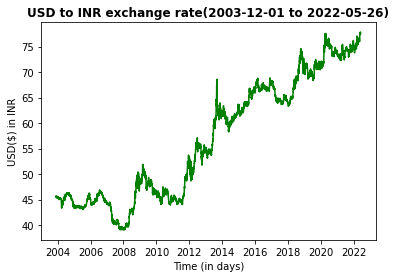

In [23]:
plt.xlabel('Time (in days)')                                                                                #Set label for x-axis
plt.ylabel('USD($) in INR')                                                                                 #Set label for y-axis
plt.plot(df[0], df['Close'], color = 'g')                                                                   #Plot  the exchange rate vs time graph
plt.title(f'USD to INR exchange rate({df.iloc[0, 0]} to {df.iloc[len(df) - 1, 0]})', fontweight = 'bold')   #Set title for the plot
plt.show()                                                                                                  #Show the plot

We expect each column among Open, Close, etc. to bear similar relationship with time. At present, we choose closing prices as our time series.

Making linear model for the exchange rate.

In [25]:
linear_model = linregress(df.index, df['Close'])

Below parameters define our linear model

In [26]:
slope, intercept, rvalue, pvalue, stderr = linear_model

Predictions of a linear model

In [27]:
linear_preds = slope*df.index + intercept

Plotting the predicted values and actual values for comparision

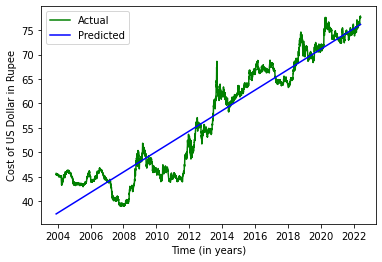

In [31]:
plt.xlabel('Time (in years)')                                                                           #Set label for x-axis 
plt.ylabel('Cost of US Dollar in Rupee')                                                                #Set label for y-axis
plt.plot(df[0], df['Close'], label = 'Actual', color = 'g')                                             #Plot the actual exchange rate vs time graph
#slope*df.index + intercept gives the predicted value for the day indicated by df.index
plt.plot(df[0],  slope*df.index + intercept, label = 'Predicted', color = 'b')                          #Plot the predicted exchange rate vs time graph
plt.legend()                                                                                            #Display legend bar
plt.show()                                                                                              #Show the plot

np.absolute(linear_preds - df['Close']).mean() calculates the absolute difference between predicted and actual values. The mean of these differences gives the average error in our predictions

In [32]:
print(f"Baseline absolute error : {np.absolute(linear_preds - df['Close']).mean()}")

Baseline absolute error : 2.9827389778363878


r-value for the predictions made by linear model

In [33]:
print(rvalue)

0.9484053911719742


## Preparing data for LSTM Model

Splitting the dataset into training and testing sets

In [34]:
train_df = df[:3500]
test_df = df[3500:]

Define a function which splits our data into proper input and output time steps, which can suitably be fed to LSTM model

In [35]:
def split_sequence_LSTM(sequence, input_time_steps, output_time_steps = 1):
    '''
       Function takes a time-series, no. of time steps in input data, and no. of time steps in label data as input
       It returns numpy arrays of LSTM input data and LSTM labels
    '''
    X, y = [], []                                                                               #Initialising the lists which will store the input and output time steps respectively.

    for i in range(len(sequence)):
        if i + input_time_steps + output_time_steps > len(sequence):                            #If no more data is available for output steps, break out of the loop.
            break
        X.append(sequence[i : i + input_time_steps])                                            #Appending a list of values which is an input sequence.
        y.append(sequence[i + input_time_steps : i + input_time_steps + output_time_steps])     #Appending a list of values which is an output sequence.
    
    X = np.array(X)                                                                             #Converting the list of input sequences into 1D np array of sequences, i.e., a 2D np array.
    X = X.reshape(X.shape[0], X.shape[1], 1)                                                    #Broadcasting 2D np array into 3D numpy array. This is only a requirement for LSTM and no change occurs to size of sequences of no. of sequences.

    y = np.array(y)                                                                             #Converting the list of output sequences into 1D np array of sequences, i.e., a 2D np array.
    
    return X, y

Converting pandas Dataframe column to numpy array, since keras models accept only numpy arrays, for the current version.

In [36]:
train = train_df['Close'].to_numpy()

In [37]:
test = test_df['Close'].to_numpy()

Converting training values to between -1 and 1

In [38]:
train = (train.mean() - train)/train.mean()

Converting testing values to between -1 and 1

In [39]:
test = (test.mean() - test)/test.mean()

## Single-step LSTM model -- Forecasting for a day

In [40]:
input_time_step_size = 175

Spliiting the training and testing dataset into input and target datasets

In [41]:
X_train, y_train = split_sequence_LSTM(train, input_time_step_size)

In [42]:
X_test, y_test = split_sequence_LSTM(test, input_time_step_size)

Verifying the shape of input and target datasets

In [43]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3325, 175, 1), (3325, 1), (3077, 175, 1), (3077, 1))

In [44]:
single_step_model = Sequential()                                                                               #Defining the model as Sequential
single_step_model.add(LSTM(50, activation='relu', input_shape=(input_time_step_size, 1)))                      #Adding LSTM layer with 50 dimensions
single_step_model.add(Dense(1))                                                                                #Adding a Dense layer, which gives out one value(i.e., the prediction)
single_step_model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = 'mean_squared_error')     #Compiling the model
single_step_model.fit(X_train, y_train, epochs = 3)                                                            #Training the model on our input and target datasets

Epoch 1/3
104/104 [==============================] - 10s 86ms/step - loss: 0.0013 - mean_squared_error: 0.0013
Epoch 2/3
104/104 [==============================] - 8s 77ms/step - loss: 6.6852e-05 - mean_squared_error: 6.6852e-05
Epoch 3/3
104/104 [==============================] - 8s 78ms/step - loss: 6.6054e-05 - mean_squared_error: 6.6054e-05


We didn't train for more epochs to avoid over-fitting

Predicting values on the training input dataset. 

In [45]:
train_preds = single_step_model.predict(X_train)

Comparing the predictions on training data and targets of training data using a plot

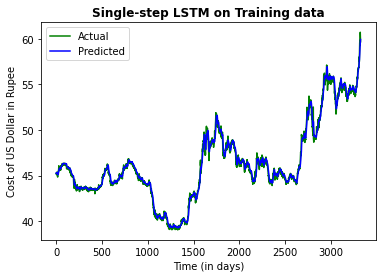

In [46]:
plt.xlabel('Time (in days)')                                                                                                         #Set label for x-axis
plt.ylabel('Cost of US Dollar in Rupee')                                                                                             #Set label for y-axis
#-(y_train*train_df['Close'].mean()) + train_df['Close'].mean() gives the value in range of y_train
plt.plot([i for i in range(y_train.shape[0])], -(y_train*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Actual', color = 'g')          #Plot the actual exchange rate vs time graph
#-(train_preds*train_df['Close'].mean()) + train_df['Close'].mean() gives the predicted value in range of y_train
plt.plot([i for i in range(train_preds.shape[0])], -(train_preds*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Predicted', color = 'b')   #Plot the predicted exchange rate vs time graph
plt.legend()                                                                                                                         #Display legend box
plt.title('Single-step LSTM on Training data', fontweight = 'bold')                                                                  #Set title for the plot
plt.show()                                                                                                                           #Show the plot

It is clear from plot that the predictions are on right track. However, to validate the model, we have to check predictions on testing dataset as well.

Predicting values on the testing input dataset.

In [47]:
test_preds = single_step_model.predict(X_test)

Comparing the predictions on testing data and targets in testing data using a plot

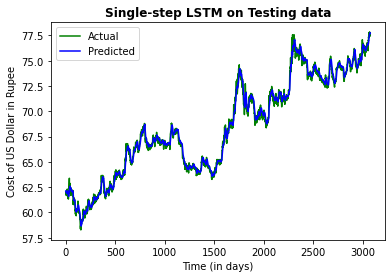

In [48]:
plt.xlabel('Time (in days)')                                                                                                                          #Set label for x-axis
plt.ylabel('Cost of US Dollar in Rupee')                                                                                                              #Set label for y-axis
#-(y_test*test_df['Close'].mean()) + test_df['Close'].mean() gives the value in range of y_test                
plt.plot([i for i in range(y_test.shape[0])], -(y_test*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Actual', color = 'g')          #Plot the actual exchange rate vs time graph
#-(preds*test_df['Close'].mean()) + test_df['Close'].mean() gives the predicted value in range of y_test
plt.plot([i for i in range(test_preds.shape[0])], -(test_preds*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Predicted', color = 'b')   #Plot the predicted exchange rate vs time graph
plt.legend()                                                                                                                                          #Display legend box
plt.title('Single-step LSTM on Testing data', fontweight = 'bold')                                                                                    #Set title for the plot
plt.show()                                                                                                                                            #Show the plot

The predictions on testing data are not good as they were for training data. This was expected since our model has not 'seen' the testing data before

Mean absolute error on training dataset

In [49]:
print(f'Mean absolute error : {np.absolute(train_preds - y_train).mean():0.4f}')

Mean absolute error : 0.0051


r2 score on training dataset

In [50]:
print(f'r2 score : {r2_score(train_preds, y_train):0.2f}')

r2 score : 0.99


Mean absolute error on testing dataset

In [51]:
print(f'Mean absolute error : {np.absolute(test_preds - y_test).mean():0.4f}')

Mean absolute error : 0.0039


r2 score on testing dataset

In [52]:
print(f'r2 score : {r2_score(test_preds, y_test):0.2f}')

r2 score : 0.99


## Multi-step LSTM Model -- Forecasting for a week

Spliiting the training dataset into input and target datasets

In [53]:
X_train, y_train = split_sequence_LSTM(train, 250, 7)

Verify the shape of input and target datasets

In [54]:
X_train.shape, y_train.shape

((3244, 250, 1), (3244, 7))

Spliiting the testing dataset into input and target datasets

In [55]:
X_test, y_test = split_sequence_LSTM(test, 250, 7)

Verify the shape of input and target datasets

In [56]:
X_test.shape, y_test.shape

((2996, 250, 1), (2996, 7))

Define a custom optimizer function with learning_rate = 1.0 (not 0.1), epsilon = 0.1 (not 1e-8), clipnorm = 1.0 (not None),

In [57]:
opt = tf.keras.optimizers.Adam(learning_rate = 1.0, beta_1 = 0.9, beta_2 = 0.999, epsilon = 0.1, decay = 0.0, clipnorm = 1.0)

Making a multi-step LSTM model.

In [58]:
multi_step_model = Sequential()                                                                               #Defining the model as Sequential
multi_step_model.add(LSTM(128, activation='relu', input_shape=(250, 1)))                                      #Adding LSTM layer with 128 dimensions
multi_step_model.add(Dense(7))                                                                                #Adding a Dense layer, which gives out 7 values(the predictions)
multi_step_model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = 'mean_squared_error')        #Compiling the model
multi_step_model.fit(X_train, y_train, epochs = 3)                                                            #Training the model on our input and target datasets

Epoch 1/3
102/102 [==============================] - 24s 225ms/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 2/3
102/102 [==============================] - 23s 224ms/step - loss: 1.7018e-04 - mean_squared_error: 1.7018e-04
Epoch 3/3
102/102 [==============================] - 24s 238ms/step - loss: 1.8150e-04 - mean_squared_error: 1.8150e-04


Again, we didn't train on more epochs because of dangers of over-fitting

Predicting values on the training input dataset.

In [59]:
train_preds = multi_step_model.predict(X_train)

Verifying the shape of prediction dataset

In [60]:
train_preds.shape

(3244, 7)

Comparing the predictions on training data and targets in training data using a plot for a randomly selected week

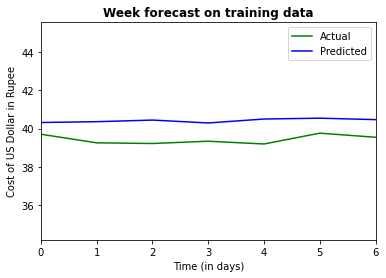

In [61]:
random_number = random.randint(0, train_preds.shape[0])                                                                                               #Generating a random number from the total range
plt.xlabel('Time (in days)')                                                                                                                          #Set label for x-axis
plt.ylabel('Cost of US Dollar in Rupee')                                                                                                              #Set label for y-axis
#-(y_train[random_number]*train_df['Close'].mean()) + train_df['Close'].mean() gives the value in range of y_train 
plt.plot([i for i in range(7)], (y_train[random_number]*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Actual', color = 'g')          #Plot the actual exchange rate vs time graph
#-(train_preds[random_number]*train_df['Close'].mean()) + train_df['Close'].mean() gives the value in range of y_train 
plt.plot([i for i in range(7)], (train_preds[random_number]*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Predicted', color = 'b')   #Plot the predicted exchange rate vs time graph
plt.xlim([0,6])                                                                                                                                       #Set x limit to plot
plt.ylim([((y_train[random_number]*train_df['Close'].mean()) + train_df['Close'].mean()).min() - 5, ((train_preds[random_number]*train_df['Close'].mean()) + train_df['Close'].mean()).max() + 5])   #Set y limit to plot
plt.legend()                                                                                                                                          #Display legend box
plt.title('Week forecast on training data', fontweight = 'bold')                                                                                      #Set title for the plot
plt.show()                                                                                                                                            #Show the plot

Predicted data is a close match to the actual data

Now, we select sequences from predicted data such that each week is covered fully and no data point is redundant

In [62]:
whole_train_preds = np.array([train_preds[i] for i in range(0, train_preds.shape[0], train_preds.shape[1])], dtype = 'object')

Converting the week sequences into a flat array

In [63]:
whole_train_preds = whole_train_preds.reshape(whole_train_preds.shape[0]*train_preds.shape[1])

Some of the data points are missed in the process, which is reflected by difference in sizes of the datasets

In [64]:
len(whole_train_preds), len(train)

(3248, 3500)

Comparing the predictions on training data and targets in training data using a plot

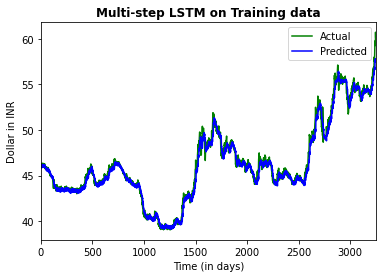

In [65]:
plt.xlabel('Time (in days)')                                                                                                                                              #Set label for x-axis
plt.ylabel('Dollar in INR')                                                                                                                                               #Set label for y-axis
#(-1)*(train*train_df['Close'].mean()) + train_df['Close'].mean() gives the value in range of train_df['Close']
plt.plot([i for i in range(len(whole_train_preds))], ((-1)*train[250:len(whole_train_preds) + 250]*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Actual', color = 'g')   #Plot the actual exchange rate vs time graph
#(-1)*(whole_train_preds*train_df['Close'].mean()) + train_df['Close'].mean() gives the value in range of train_df['Close']
plt.plot([i for i in range(len(whole_train_preds))], ((-1)*whole_train_preds*train_df['Close'].mean()) + train_df['Close'].mean(), label = 'Predicted', color = 'b')                  #Plot the predicted exchange rate vs time graph
plt.xlim([0, len(whole_train_preds)])                                                                                                                                           #Set x limit to plot
plt.legend()                                                                                                                                                              #Display legend box       
plt.title('Multi-step LSTM on Training data', fontweight = 'bold')                                                                                                        #Set title for the plot
plt.show()                                                                                                                                                                #Show the plot

Overall, our model is making right predictions on the training dataset, as seen in the plot.

Now, let's turn for testing dataset.

Predicting values on the testing input dataset.

In [66]:
test_preds = multi_step_model.predict(X_test)

Verifying the shape of prediction dataset

In [67]:
test_preds.shape

(2996, 7)

Comparing the predictions on training data and targets in training data using a plot for a randomly selected week

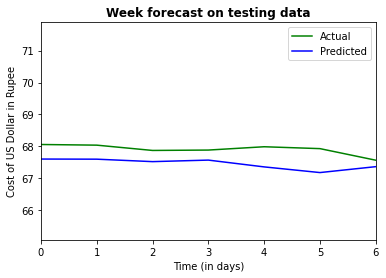

In [68]:
random_number = random.randint(0, test_preds.shape[0])                                                                                                     #Generating a random number from the total range
plt.xlabel('Time (in days)')                                                                                                                               #Set label for x-axis
plt.ylabel('Cost of US Dollar in Rupee')                                                                                                                   #Set label for y-axis
#(-1)*(y_test[random_number]*test_df['Close'].mean()) + test_df['Close'].mean() gives the value in range of test_df['Close']
plt.plot([i for i in range(7)], (-1)*(y_test[random_number]*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Actual', color = 'g')             #Plot the actual exchange rate vs time graph
#(-1)*(test_preds[random_number-1]*test_df['Close'].mean()) + test_df['Close'].mean() gives the value in range of test_df['Close']
plt.plot([i for i in range(7)], (-1)*(test_preds[random_number-1]*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Predicted', color = 'b')    #Plot the predicted exchange rate vs time graph
plt.xlim([0,6])                                                                                                                                            #Set x limit to plot
plt.ylim([((y_test[random_number]*test_df['Close'].mean()) + test_df['Close'].mean()).min() - 3, ((test_preds[random_number]*test_df['Close'].mean()) + test_df['Close'].mean()).max() + 3])   #Set y limit to plot
plt.legend()                                                                                                                                               #Display legend box
plt.title('Week forecast on testing data', fontweight = 'bold')                                                                                            #Set title for the plot
plt.show()                                                                                                                                                 #Show the plot

The predictions for week in case of testing dataset seem good. But before making any conclusions, let's check the entire predicitons.

Now, we select sequences from predicted data such that each week is covered fully and no data point is redundant

In [69]:
whole_test_preds = np.array([test_preds[i] for i in range(0, test_preds.shape[0], 7)], dtype = 'object')

Converting the week sequences into a flat array

In [70]:
whole_test_preds = whole_test_preds.reshape(whole_test_preds.shape[0]*7)

Some of the data points are missed in the process, which is reflected by difference in sizes of the datasets

In [71]:
whole_test_preds.shape, test.shape

((2996,), (3252,))

Comparing the predictions on training data and targets in training data using a plot

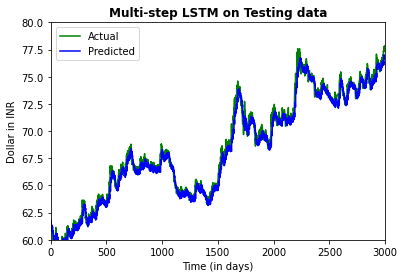

In [72]:
plt.xlabel('Time (in days)')                                                                                                                                             #Set label for x-axis
plt.ylabel('Dollar in INR')                                                                                                                                              #Set label for y-axis
#((-1)*test[250:len(whole_test_preds)]*test_df['Close'].mean()) + test_df['Close'].mean() gives the value in range of test_df['Close']
plt.plot([i for i in range(len(whole_test_preds))], ((-1)*test[250:len(whole_test_preds) + 250]*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Actual', color = 'g')     #Plot the actual exchange rate vs time graph
#((-1)*whole_test_preds*test_df['Close'].mean()) + test_df['Close'].mean() gives the value in range of test_df['Close']
plt.plot([i for i in range(len(whole_test_preds))], ((-1)*whole_test_preds*test_df['Close'].mean()) + test_df['Close'].mean(), label = 'Predicted', color = 'b')         #Plot the predicted exchange rate vs time graph
plt.xlim([0, len(test) - 250])                                                                                                                                           #Set x limit to plot
plt.ylim([60, 80])                                                                                                                                                       #Set y limit to plot
plt.legend()                                                                                                                                                             #Display legend box
plt.title('Multi-step LSTM on Testing data', fontweight = 'bold')                                                                                                        #Set title for the plot
plt.show()                                                                                                                                                               #Show the plot

Model is not doing better on testing data when compared to its performance on training data. We need to do some quantitative measurements to arrive at conclusion.

Mean absolute error of predictions from actual value on training dataset

In [73]:
print(f"Mean absolute error : {np.absolute((whole_train_preds - train[250 : whole_train_preds.shape[0] + 250])*train_df['Close'].mean()).mean():0.2f}")

Mean absolute error : 0.39


r2 score of predictions on training dataset

In [74]:
print(f"r2 score : {r2_score(whole_train_preds, train[250 : whole_train_preds.shape[0] + 250]):0.2f}")

r2 score : 0.98


Mean absolute error of predictions from actual value on testing dataset

In [76]:
print(f"Mean absolute error : {np.absolute((whole_test_preds - test[250:whole_test_preds.shape[0] + 250])*test_df['Close'].mean()).mean():0.2f}")

Mean absolute error : 0.44


r2 score of predictions on testing dataset

In [77]:
print(f"r2 score : {r2_score(whole_test_preds, test[250:whole_test_preds.shape[0] + 250]):0.2f}")

r2 score : 0.98


The model is doing great on the testing dataset with an r2 score of 0.98. The mean absolute error is about 0.44, which is not bad, and is smaller than baseline.

So as seen from graph, deviations of prediction from actual values are quite small.

Hence, our model is overall a good one.

In [78]:
# # # Copyright (C) 2022  Syed Salman Habeeb Quadri
# # # https://github.com/SalmanHabeeb/INR-Predictor/blob/main/License%20Notice.md